In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

from numpy import *
from IPython.html.widgets import *
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Gabor Filters

# What are Gabor filters?

* Gabor filter, named after the physicist and electrical engineer Dennis Gabor, is a linear filter used for edge detection in image processing.

<img src="files/images/Gabors/Dennis_Gabor.jpg" style="margin:auto; width: 211px;"/>

(Trivia: Dennis Gabor invented holography and received Nobel Prize in 1971!) 

Gabor filters were originally introduced as an acoustic (1D) filter to explain audition. 

<img src="files/images/Gabors/paper.png" style="margin:auto; width: 25%;"/>

A Gabor filter is a product of the *Gaussian envelope* and the (complex) *sinusoidal carrier*:

$$g(x; \sigma, f, \phi) = \underbrace{\exp\left( -\frac{x^2}{2 \sigma^2} \right)}_{\textrm{Gaussian}}
\underbrace{ \exp\left( i \left(\frac{2 \pi x}{f} + \phi \right) \right)}_{\textrm{Sinusoid}}$$

Remember, $e^{i x} = \cos x + i \sin x$; so the filter has both real and imaginary parts.

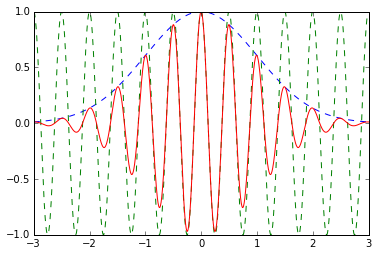

In [2]:
xs=linspace(-3, 3, 1000)
gaussian=exp(-xs**2/2)
sinusoid=exp(1j*2*pi*xs/0.5) # 1j is "i"
plt.plot(xs, gaussian, '--')
plt.plot(xs, real(sinusoid), '--')
plt.plot(xs, gaussian*real(sinusoid))

Similarly, we can characterize 2D Gabor filters using:

 * For the Gaussian part: standard deviations $\sigma_x$ and $\sigma_y$
 * For the sinuosoid part: the frequency $f$ and phase offset $\phi$
 * Rotate the the filter with angle $\theta$

Exercise 1. Let's create some 2D Gabor filters and visualize them.  Try typing the following:

(-0.5, 36.5, 36.5, -0.5)

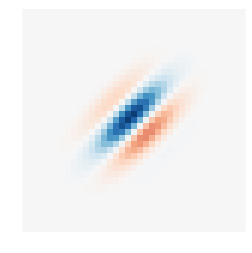

In [3]:
#from skimage.filters import gabor_kernel   
#   ^--- if you have latest version of scikit-image installed.
from filters import gabor_kernel

g=gabor_kernel(frequency=0.1, theta=pi/4, 
               sigma_x=3.0, sigma_y=5.0, offset=pi/5, n_stds=5)
plt.imshow(real(g), cmap='RdBu', interpolation='none', 
           vmin=-abs(g).max(), vmax=abs(g).max())
plt.axis('off')  

## What do Gabor filters do?

 * Gabor filters are good **feature detectors**.
 * Each filter is sensitive to **edges** with specific **orientations** at specific **locations**.
 * However, there is a trade-off between spatial resolution and frequency resolution ("Uncertainty Principle").
   * If you have high spatial resolution (know where the edge occurs), you have less certainty in the frequency contents.
 * It turns out, mathematically, Gabor filter achieves a kind of optimal space-time trade-off. 

For the purposes of cognitive modeling, however, the most important is that the filter responses achieve **translation invariance**: that is, the *magnitude* of the (complex) filter response doesn't change very much when the image is shifted slightly.

Exercise 2. Let's apply different Gabor filters to an image and visualize the filter responses.

(This can be done very easily using `skimage.filters.gabor_filter` function.)

Try changing the values in the sliders. Note how the magnitude of the complex response (`response = abs`) provides some *shift invariance* - that is, the response changes less even when the image is shifted slightly (`image_shift_x` and `image_shift_y`.)

In [16]:
# The code to create interactive plots

def plot_gabor_filtering(dataset, image_id, frequency, theta, response_fn=real, image_shift_x=0, image_shift_y=0):
    """Plots the results of the real part of the Gabor filter."""
    image = dataset.images[image_id]
    H, W = image.shape
    original=pad(dataset.images[image_id], ((image_shift_y,0), (image_shift_x,0)), mode='reflect')[:H,:W]
    fig, axs = plt.subplots(1, 4, figsize=(15,5))
    axs[0].imshow(original,cmap='gray',interpolation='none')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    delta_image=zeros(original.shape, dtype=float)
    delta_image[tuple(array(delta_image.shape)/2)]=1.0 # 1.0 at the center
    kernel_real, kernel_imag=gabor_filter(delta_image, frequency=frequency, theta=theta)
    kernel=kernel_real + 1j*kernel_imag
    axs[1].imshow(response_fn(kernel),cmap='gray',interpolation='none')
    axs[1].set_title('Filter (%s)' % response_fn.__name__)
    axs[1].axis('off')
    
    response_real,response_imag=gabor_filter(original, frequency=frequency, theta=theta)
    response=response_real + 1j*response_imag
    axs[2].imshow(response_fn(response),cmap='gray',interpolation='none')
    axs[2].set_title('Filter Response')
    axs[2].axis('off')
    
    unshifted_real,unshifted_imag=gabor_filter(image, frequency=frequency, theta=theta)
    unshifted_response=unshifted_real + 1j*unshifted_imag
    difference=(response_fn(response)-response_fn(unshifted_response)) / response_fn(unshifted_response).std()
    axs[3].imshow(difference,cmap='gray',interpolation='none', vmin=-2, vmax=2)
    axs[3].set_title('Difference from unshifted (NRMSE=%f)' % sqrt((difference**2).mean()))
    axs[3].axis('off')

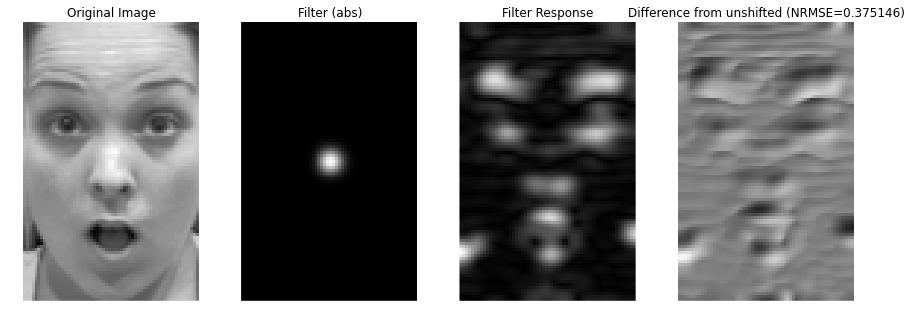

In [17]:
#from skimage.filters import gabor_filter
from filters import gabor_filter
import pickle
dataset=pickle.load(open('data/cafe.pkl','r')) # or 'pofa.pkl' for POFA

interactive(plot_gabor_filtering, 
            dataset=fixed(dataset),
            image_id=(0,dataset.images.shape[0]-1),
            frequency=FloatSlider(min=0.001, max=0.5, value=0.1),
            theta=FloatSlider(min=0, max=pi, value=pi / 2.0),
            response_fn={'Real': real, 'Imag': imag, 'Abs': abs},
            image_shift_x=IntSlider(min=0, max=10, value=0),
            image_shift_y=IntSlider(min=0, max=10, value=0))

## But, why do we use Gabor filters for cognitive modeling?

* It turns out Gabor filters are good model for capturing the *statistics* of natural images.
* To the extent that our sensory apparatuses have evolved to efficiently encode the statistics of the world we live in (Barlow’s "efficient coding hypothesis"), the statistics of natural images reveal the workings of our perceptual system - in this case, the visual cortex (V1).